# Imports

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [14]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [12]:
import random
import numpy as np
import pandas as pd

import optuna

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score

from sklearn.decomposition import PCA

from sklearn.datasets import load_breast_cancer

import statistics as st
from scipy import stats

# Functions

In [ ]:
class RidgeRegression:
    def __init__(self, max_tau):
        self.x_train = None
        self.y_train = None
        self.n = None
        self.theta = None
        self.max_tau = max_tau
        self.history = []
        self.best_tau = None

    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
        self.n = x_train.shape[1]

        min_error = np.inf

        for tau in np.linspace(0.1, self.max_tau, 500):
            theta = self.calculate_param_vector(tau)
            y_pred = theta @ self.x_train.T
            error = self.empirical_risk(self.y_train, y_pred, tau, theta)
            self.history.append(error)
            if error < min_error:
                self.best_tau = tau
                min_error = error
                self.theta = theta

    def empirical_risk(self, y_true, y_pred, tau, theta):
        return np.sum(np.square(y_pred - y_true)) + tau * np.sum(np.square(theta))

    def calculate_param_vector(self, tau):
        return np.linalg.inv(self.x_train.T @ self.x_train + tau * np.eye(self.n)) @ self.x_train.T @ self.y_train

    def predict(self, x):
        return self.theta @ x.T

    def get_params(self):
        return self.theta

    def score(self, y_test, y_pred):
        return mean_squared_error(y_test, y_pred)

class RidgeClassifier(RidgeRegression):
    def __init__(self, max_tau=2):
        super().__init__(max_tau)

    def fit(self, x_train, y_train):
        super().fit(x_train, y_train)

    def predict(self, x_test):
        return np.sign(super().predict(x_test))

    def get_params(self):
        return super().get_params()

    def score(self, y_test, y_pred):
        return accuracy_score(y_test, y_pred)

In [4]:
class GradientClassifier:
    def __init__(
            self,
            empirical_risk='piecewise',
            lr=0.1,
            tau1_range=np.linspace(0, 2, 5),
            tau2_range=np.linspace(1, 2, 5),
            max_iter=1000
    ):
        risks = {
            "piecewise": lambda y_true, y_pred, a, b, theta: -1 * np.sum(y_true * y_pred)
                               + a * np.sum(np.square(theta)) + b * np.sqrt(np.sum(np.square(theta))),
            "exponential": lambda y_true, y_pred, a, b, theta: np.exp(-1 * np.sum(y_true * y_pred))
                               + a * np.sum(np.square(theta)) + b * np.sqrt(np.sum(np.square(theta))),
            "square": lambda y_true, y_pred, a, b, theta: np.square(1 - np.sum(y_true * y_pred))
                               + a * np.sum(np.square(theta)) + b * np.sqrt(np.sum(np.square(theta))),
        }
        self.empirical_risk = risks[empirical_risk]
        self.max_iter = max_iter
        self.best_error = np.inf
        self.lr = lr
        self.tau1_range = tau1_range
        self.tau2_range = tau2_range
        self.x_train = None
        self.y_train = None
        self.best_params = None
        self.best_tau1 = None
        self.best_tau2 = None
        self.history_emp = []
        self.history_accuracy = []

    def calculate_param_vector(self, tau1, tau2):
        best_local_error = np.inf
        theta = np.zeros(self.x_train.shape[1], dtype=float)
        best_local_params = None
        loss_for_hist = []
        accuracy_for_hist = []
        for i in range(self.max_iter):
            r = np.random.randint(0, len(self.x_train))
            grad = (np.dot(self.x_train[r], theta) - self.y_train[r]) * self.x_train[r]
            alpha = (np.dot(theta, self.x_train[r]) - self.y_train[r]) / np.dot(grad, self.x_train[r])

            theta = theta * (1 - alpha) - self.lr * alpha * grad
            err = self.empirical_risk(self.y_train, self.x_train @ theta, tau1, tau2, theta)
            loss_for_hist.append(err)
            pred_iter = np.sign(self.x_train @ theta)

            accuracy_iter = self.score(pred_iter, self.y_train)
            accuracy_for_hist.append(accuracy_iter)

            if i % 20 == 0:
                self.history_emp.append(np.mean(loss_for_hist))
                loss_for_hist = []
                self.history_accuracy.append(np.mean(accuracy_for_hist))
                accuracy_for_hist = []

            if best_local_error > err:
                best_local_error = err
                best_local_params = theta

        if self.best_error > best_local_error:
            self.best_params = best_local_params
            self.best_error = best_local_error
            self.best_tau1 = tau1
            self.best_tau2 = tau2
        return best_local_error, best_local_params

    def fit(self, X_train, y_train):
        self.x_train = X_train
        self.y_train = y_train
        self.calculate_best_params()
        return self

    def calculate_best_params(
            self
    ):
        for i in self.tau1_range:
            for j in self.tau2_range:
                self.calculate_param_vector(i, j)

    def calculate_params(self, i, j):
        self.calculate_param_vector(i, j)

    def fit_with_known_bwst(self, X_train, y_train, i, j):
        self.x_train = X_train
        self.y_train = y_train
        self.calculate_params(i, j)
        return self

    def predict(self, X_test):
        return np.sign(X_test @ self.best_params)

    def score(self, y_test, y_pred):
        return accuracy_score(y_test, y_pred)


In [5]:
np.random.seed(1234)
class GradientClassifierForTest:
    def __init__(
            self,
            empirical_risk='piecewise',
            lr=0.1,
            tau1_range=np.linspace(0, 2, 5),
            tau2_range=np.linspace(1, 2, 5),
            max_iter=1000
    ):
        risks = {
            "piecewise": lambda y_true, y_pred, a, b, theta: -1 * np.sum(y_true * y_pred)
                               + a * np.sum(np.square(theta)) + b * np.sqrt(np.sum(np.square(theta))),
            "exponential": lambda y_true, y_pred, a, b, theta: np.exp(-1 * np.sum(y_true * y_pred))
                               + a * np.sum(np.square(theta)) + b * np.sqrt(np.sum(np.square(theta))),
            "square": lambda y_true, y_pred, a, b, theta: np.square(1 - np.sum(y_true * y_pred))
                               + a * np.sum(np.square(theta)) + b * np.sqrt(np.sum(np.square(theta))),
        }
        self.empirical_risk = risks[empirical_risk]
        self.max_iter = max_iter
        self.best_error = np.inf
        self.lr = lr
        self.tau1_range = tau1_range
        self.tau2_range = tau2_range
        self.x_train = None
        self.y_train = None
        self.best_params = None
        self.best_tau1 = None
        self.best_tau2 = None
        self.history_emp = []
        self.history_accuracy = []
        self.history_mean_accuracy = []

    def calculate_param_vector(self, tau1, tau2):
        best_local_error = np.inf
        theta = np.zeros(self.x_train.shape[1], dtype=float)
        best_local_params = None
        loss_for_hist = []
        accuracy_for_hist = []
        for i in range(self.max_iter):
            r = np.random.randint(0, len(self.x_train))
            grad = (np.dot(self.x_train[r], theta) - self.y_train[r]) * self.x_train[r]
            alpha = (np.dot(theta, self.x_train[r]) - self.y_train[r]) / np.dot(grad, self.x_train[r])

            theta = theta * (1 - alpha) - self.lr * alpha * grad
            err = self.empirical_risk(self.y_train, self.x_train @ theta, tau1, tau2, theta)
            loss_for_hist.append(err)


            pred_iter = np.sign(self.x_test @ theta)
            accuracy_iter = self.score(pred_iter, self.y_test)

            accuracy_for_hist.append(accuracy_iter)
            if i % 100 == 0:
                self.history_mean_accuracy.append(np.mean(accuracy_for_hist))
                accuracy_for_hist = []
                self.history_accuracy.append(accuracy_iter)

            if best_local_error > err:
                best_local_error = err
                best_local_params = theta

        if self.best_error > best_local_error:
            self.best_params = best_local_params
            self.best_error = best_local_error
            self.best_tau1 = tau1
            self.best_tau2 = tau2
        return best_local_error, best_local_params

    def fit(self, X_train, y_train):
        self.x_train = X_train
        self.y_train = y_train
        self.calculate_best_params()
        return self

    def calculate_best_params(
            self
    ):
        for i in self.tau1_range:
            for j in self.tau2_range:
                self.calculate_param_vector(i, j)

    def calculate_params(self, i, j):
        self.calculate_param_vector(i, j)

    def fit_with_known_bwst(self, X_train, y_train, X_test, y_test, i, j):
        self.x_train = X_train
        self.y_train = y_train
        self.x_test = X_test
        self.y_test = y_test
        self.calculate_params(i, j)
        return self

    def predict(self, X_test):
        return np.sign(X_test @ self.best_params)

    def score(self, y_test, y_pred):
        return accuracy_score(y_test, y_pred)


In [54]:
class SVMClassifier:
    def __init__(
            self,
            kernel='square',
            C=0.1,
            polynom_degree=2,
            lr=0.01,
            max_iter=1000
    ):
        all_kernels = {
            "linear": lambda a, b, d: a.dot(b.T),
            "polynom": lambda a, b, d: (1 + a @ b.T) ** d,
            "square": lambda a, b, d: (a @ b.T)**2
        }
        self.iter = max_iter

        self.kernel = all_kernels[kernel]

        self.C = C
        self.d = polynom_degree
        self.lr = lr

        self.x_train = None
        self.y_train = None
        self.kernels = None
        self.alphas = None

        self.n = 0
        self.b = 0
        self.loss = 0
        self.history_loss = []
        self.history_accuracy = []


    def fit(self, X_train, y_train):
        self.x_train = X_train
        self.y_train = y_train
        self.n = self.x_train.shape[0]
        b = np.where(self.y_train < 0)[0]
        a = np.where(self.y_train > 0)[0]
        self.alphas = np.full(self.n, 0.0)
        alphas = np.full(self.n, 0.0)
        self.kernels = np.outer(self.y_train, self.y_train) * self.kernel(self.x_train, self.x_train, self.d)

        loss_for_hist = []
        accuracy_for_hist = []

        for i in range(self.iter):
            grad = 1 - self.kernels @ alphas
            alphas += self.lr * grad
            alphas[alphas > self.C] = self.C
            alphas[alphas < 0] = 0

            if abs(np.sum(alphas[b]) - np.sum(alphas[a])) > 10e-9:
                if np.sum(alphas[b]) > np.sum(alphas[a]):
                    between = np.sum(alphas[b]) - np.sum(alphas[a])
                    for a_index in a:
                        alphas[a_index] = min(self.C, alphas[a_index] + between/alphas[a].shape[0])
                elif np.sum(alphas[a]) > np.sum(alphas[b]):
                    between = np.sum(alphas[a]) - np.sum(alphas[b])
                    for b_index in b:
                        alphas[b_index] = min(self.C, alphas[b_index] + between/alphas[b].shape[0])

            loss = np.sum(alphas) - 0.5 * np.sum(
                np.outer(alphas, alphas) * self.kernels)
            if loss > self.loss:
                self.alphas = alphas
                self.loss = loss
            loss_for_hist.append(loss)
            y_pred = np.sign(self.decision_alpha(self.x_train, self.x_train, alphas))
            noe_accuracy = accuracy_score(y_pred, self.y_train)
            accuracy_for_hist.append(noe_accuracy)

            if i % 100 == 0:
                self.history_loss.append(np.mean(loss_for_hist))
                loss_for_hist = []
                self.history_accuracy.append(np.mean(accuracy_for_hist))
                accuracy_for_hist = []



        significants = np.where(self.alphas > 0 & (self.alphas <= self.C))[0]

        b_list = []
        for i in significants:
            b_list.append(self.y_train[i] - (self.alphas * self.y_train).dot(self.kernel(self.x_train, self.x_train[i], self.d)))

        self.b = np.mean(b_list)
        return self

    def predict(self, x_test):
        res = self.decision(self.x_train, x_test)
        return np.sign(res)

    def decision(self, z, x_test):
        return (self.alphas * self.y_train).dot(self.kernel(z, x_test, self.d)) + self.b

    def decision_alpha(self, z, x_test, alphas):
        return (alphas * self.y_train).dot(self.kernel(z, x_test, self.d)) + self.b

In [55]:
class SVMClassifierForTest:
    def __init__(
            self,
            kernel='square',
            C=0.1,
            polynom_degree=2,
            lr=0.01,
            max_iter=1000
    ):
        all_kernels = {
            "linear": lambda a, b, d: a.dot(b.T),
            "polynom": lambda a, b, d: (1 + a @ b.T) ** d,
            "square": lambda a, b, d: (a @ b.T)**2
        }
        self.iter = max_iter

        self.kernel = all_kernels[kernel]

        self.C = C
        self.d = polynom_degree
        self.lr = lr

        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.kernels = None
        self.alphas = None

        self.n = 0
        self.b = 0
        self.loss = 0
        self.history_mean_accuracy = []
        self.history_accuracy = []


    def fit(self, X_train, y_train, X_test, y_test):
        self.x_train = X_train
        self.y_train = y_train
        self.x_test = X_test
        self.y_test = y_test

        self.n = self.x_train.shape[0]
        b = np.where(self.y_train < 0)[0]
        a = np.where(self.y_train > 0)[0]
        self.alphas = np.full(self.n, 0.0)
        alphas = np.full(self.n, 0.0)

        self.kernels = np.outer(self.y_train, self.y_train) * self.kernel(self.x_train, self.x_train, self.d)
        accuracy_for_hist = []

        for i in range(self.iter):
            grad = 1 - self.kernels @ alphas
            alphas += self.lr * grad
            alphas[alphas > self.C] = self.C
            alphas[alphas < 0] = 0

            if abs(np.sum(alphas[b]) - np.sum(alphas[a])) > 10e-9:
                if np.sum(alphas[b]) > np.sum(alphas[a]):
                    between = np.sum(alphas[b]) - np.sum(alphas[a])
                    for a_index in a:
                        alphas[a_index] = min(self.C, alphas[a_index] + between/alphas[a].shape[0])
                elif np.sum(alphas[a]) > np.sum(alphas[b]):
                    between = np.sum(alphas[a]) - np.sum(alphas[b])
                    for b_index in b:
                        alphas[b_index] = min(self.C, alphas[b_index] + between/alphas[b].shape[0])

            loss = np.sum(alphas) - 0.5 * np.sum(
                np.outer(alphas, alphas) * self.kernels)
            if loss > self.loss:
                self.alphas = alphas
                self.loss = loss

            y_pred = np.sign(self.decision_alpha(self.x_train, self.x_test, alphas))
            noe_accuracy = accuracy_score(y_pred, self.y_test)

            accuracy_for_hist.append(noe_accuracy)

            if i % 100 == 0:
                self.history_mean_accuracy.append(np.mean(accuracy_for_hist))
                accuracy_for_hist = []
                self.history_accuracy.append(noe_accuracy)

        significants = np.where(self.alphas > 0 & (self.alphas <= self.C))[0]

        b_list = []
        for i in significants:
            b_list.append(self.y_train[i] - (self.alphas * self.y_train).dot(self.kernel(self.x_train, self.x_train[i], self.d)))

        self.b = np.mean(b_list)
        return self

    def predict(self, x_test):
        res = self.decision(self.x_train, x_test)
        return np.sign(res)

    def decision(self, z, x_test):
        return (self.alphas * self.y_train).dot(self.kernel(z, x_test, self.d)) + self.b

    def decision_alpha(self, z, x_test, alphas):
        return (alphas * self.y_train).dot(self.kernel(z, x_test, self.d)) + self.b

In [8]:
optuna.logging.set_verbosity(optuna.logging.WARN)


def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [9]:
def MinMax(foo):
    cols_n = foo.shape[1]
    for i in range(cols_n):
        v = foo[:, i]
        foo[:, i] = (v - v.min()) / (v.max() - v.min())
    return foo

In [10]:
def confidence_interval(data, alpha=0.95):
    # alpha заменили на confidence
    l, r = stats.t.interval(alpha, df=len(data)-1, loc=st.mean(data), scale=stats.sem(data))
    m = (l + r) / 2
    e = r - m
    return m, e

# Best params

ridge

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
X = MinMax(X)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RidgeClassifier(max_tau=3)
model.fit(X_train, y_train)
model.best_tau

0.1

GradientClassifier

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
X = MinMax(X)
y[y == 0] = -1
X_train, X_test, _, _ = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def objective_fixed(trial):
    y_pred = GradientClassifier(
        empirical_risk=trial.suggest_categorical('empirical_risk', ['piecewise', "exponential", 'square']),
        lr=trial.suggest_categorical('lr', [0.001, 0.01, 0.05, 0.1, 1]),
        max_iter=500
    ).fit(X_train_v, y_train_v
          ).predict(X_valid)

    return accuracy_score(y_valid, y_pred)

study_fixed = optuna.create_study(direction="maximize")
study_fixed.optimize(objective_fixed, n_trials=100, show_progress_bar=True, callbacks=[logging_callback])

  0%|          | 0/100 [00:00<?, ?it/s]

Trial 0 finished with best value: 0.4065934065934066 and parameters: {'empirical_risk': 'piecewise', 'lr': 1}. 
Trial 1 finished with best value: 0.8241758241758241 and parameters: {'empirical_risk': 'square', 'lr': 0.05}. 
Trial 9 finished with best value: 0.8681318681318682 and parameters: {'empirical_risk': 'piecewise', 'lr': 1}. 


In [ ]:
print(study_fixed.best_params)
print(study_fixed.best_value)

{'empirical_risk': 'piecewise', 'lr': 1}
0.8681318681318682


SVMClassifier

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
X = MinMax(X)
pca = PCA(n_components=2)
X = pca.fit_transform(X)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def objective_svm_nonpoly(trial):
    y_pred = SVMClassifier(
        kernel=trial.suggest_categorical('kernel', ['square', "linear"]),
        lr=trial.suggest_categorical('lr', [0.001, 0.01, 0.05, 0.1, 1]),
        C=trial.suggest_categorical("C", [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0])
    ).fit(X_train_v, y_train_v).predict(X_valid)

    return accuracy_score(y_valid, y_pred)

study_svm_nonpoly = optuna.create_study(direction="maximize")
study_svm_nonpoly.optimize(objective_svm_nonpoly, n_trials=100, show_progress_bar=True, callbacks=[logging_callback])

  0%|          | 0/100 [00:00<?, ?it/s]

Trial 0 finished with best value: 0.8351648351648352 and parameters: {'kernel': 'linear', 'lr': 0.05, 'C': 0.05}. 


In [ ]:
print(study_svm_nonpoly.best_params)
print(study_svm_nonpoly.best_value)

{'kernel': 'linear', 'lr': 0.05, 'C': 0.05}
0.8351648351648352


In [ ]:
def objective_svm_poly(trial):
    y_pred = SVMClassifier(
        kernel="polynom",
        polynom_degree=trial.suggest_categorical('polynom_degree', [1, 2, 3, 4]),
        lr=trial.suggest_categorical('lr', [0.001, 0.01, 0.05, 0.1, 1]),
        C=trial.suggest_categorical("C", [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0])
    ).fit(X_train_v, y_train_v).predict(X_valid)

    return accuracy_score(y_valid, y_pred)

study_svm_poly = optuna.create_study(direction="maximize")
study_svm_poly.optimize(objective_svm_poly, n_trials=100, show_progress_bar=True, callbacks=[logging_callback])

  0%|          | 0/100 [00:00<?, ?it/s]

Trial 0 finished with best value: 0.6813186813186813 and parameters: {'polynom_degree': 4, 'lr': 0.05, 'C': 5.0}. 
Trial 1 finished with best value: 0.8351648351648352 and parameters: {'polynom_degree': 1, 'lr': 0.01, 'C': 5.0}. 


In [ ]:
print(study_svm_poly.best_params)
print(study_svm_poly.best_value)

{'polynom_degree': 1, 'lr': 0.01, 'C': 5.0}
0.8351648351648352


# Learning curve

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
X = MinMax(X)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = GradientClassifier(empirical_risk='piecewise', lr=0.1)
model.fit_with_known_bwst(X_train, y_train, 0.5, 1.75)
y_pr = model.predict(X_test)
model.score(y_test, y_pr)

0.9122807017543859

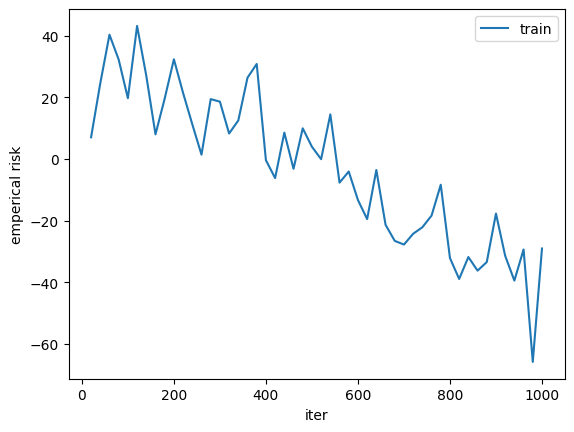

In [ ]:
x_ticks = []
for i in range(len(model.history_accuracy)):
    x_ticks.append(i*20 + 20)
plt.plot(x_ticks, model.history_emp, label='train')
plt.legend()
plt.xlabel('iter')
plt.ylabel('emperical risk')
plt.show()

**SVM**

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
X = MinMax(X)
pca = PCA(n_components=2)
X = pca.fit_transform(X)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = SVMClassifier(kernel="polynom", polynom_degree=1, lr=0.01, C=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8771929824561403

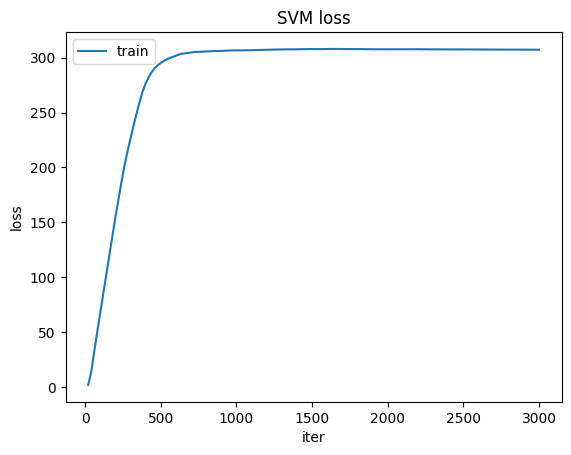

In [ ]:
x_ticks = []
for i in range(len(model.history_accuracy)):
    x_ticks.append(i*20 + 20)

plt.plot(x_ticks, model.history_loss, label='train')
plt.legend()
plt.title("SVM loss")
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

# Accuracy curve

**SVM**

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
X = MinMax(X)
pca = PCA(n_components=2)
X = pca.fit_transform(X)
y[y == 0] = -1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = SVMClassifierForTest(kernel="polynom", polynom_degree=1, lr=0.01, C=5)
model.fit(X_train, y_train, X_test, y_test)

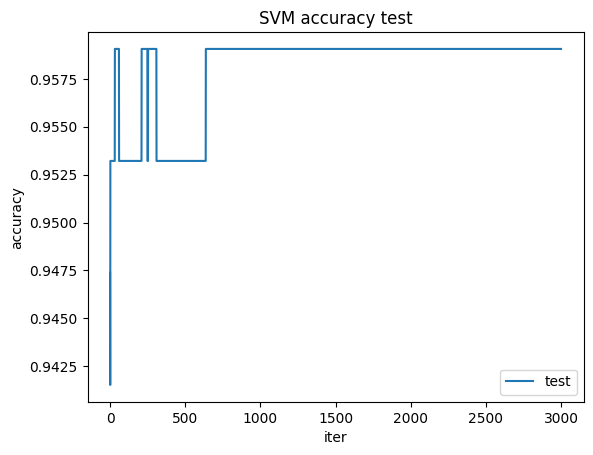

In [ ]:
plt.plot(range(len(model.history_accuracy)), model.history_accuracy, label='test')
plt.legend()
plt.title("SVM accuracy test")
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.show()

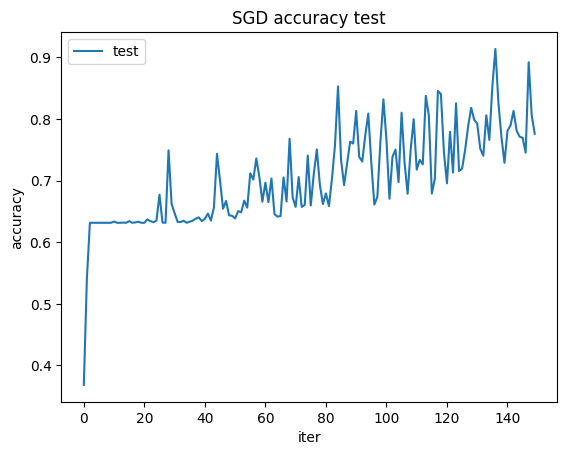

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
X = MinMax(X)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = GradientClassifierForTest(empirical_risk='piecewise', lr=0.1, max_iter=3000)
model.fit_with_known_bwst(X_train, y_train, X_test, y_test, 0.5, 1.75)
plt.plot(range(len(model.history_accuracy)), model.history_accuracy, label='test')
plt.legend()
plt.title("SGD accuracy test")
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.show()

# Different splits

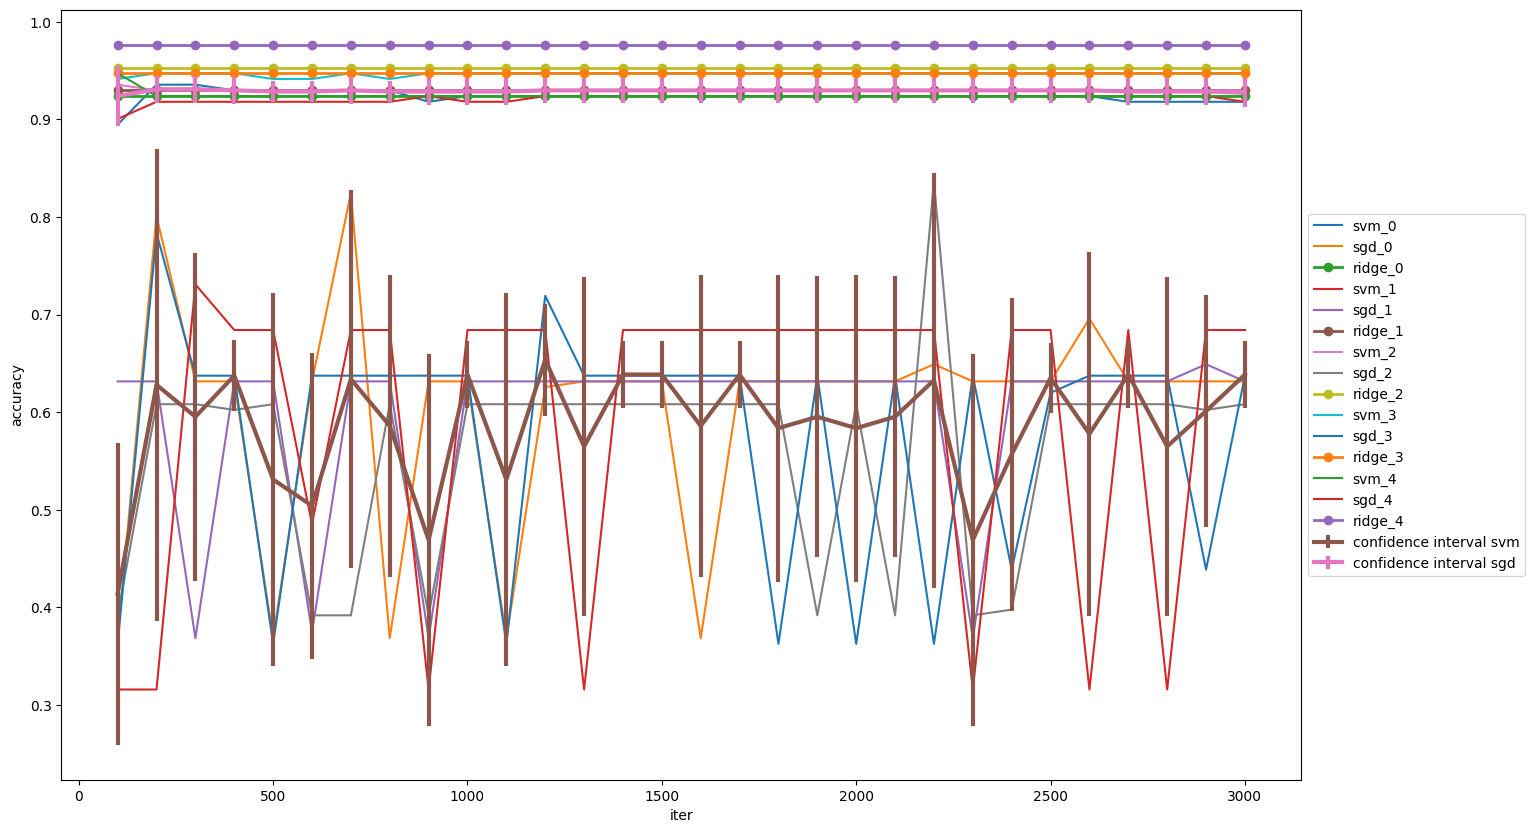

In [ ]:
X_base, y = load_breast_cancer(return_X_y=True)
y[y == 0] = -1
X_svm = MinMax(X_base)
pca = PCA(n_components=2)
X_svm = pca.fit_transform(X_svm)

X_sgd = MinMax(X_base)
x_ticks = []
for i in range(30):
    x_ticks.append(i*100 + 100)

plt.figure(figsize=(16,10))
svm_all_accur= []
sgd_accur_all= []
for irs in range(5):

    X_train, X_test, y_train, y_test = train_test_split(X_svm, y, test_size=0.3, random_state=irs)
    model = SVMClassifierForTest(kernel="polynom", polynom_degree=1, lr=0.01, C=5)
    model.fit(X_train, y_train, X_test, y_test)
    svm_all_accur.append(model.history_accuracy)
    plt.plot(x_ticks, model.history_accuracy, label=f"svm_{irs}")

    X_train, X_test, y_train, y_test = train_test_split(X_sgd, y, test_size=0.3, random_state=irs)
    model = GradientClassifierForTest(empirical_risk='piecewise', lr=0.1, max_iter=3000)
    model.fit_with_known_bwst(X_train, y_train, X_test, y_test, 0.5, 1.75)
    sgd_accur_all.append(model.history_accuracy)
    plt.plot(x_ticks, model.history_accuracy, label=f"sgd_{irs}")

    model = RidgeClassifier(max_tau=1)
    model.fit(X_train, y_train)
    y_pr = model.predict(X_test)
    err_ridge = model.score(y_test, y_pr)
    plt.plot(x_ticks, np.repeat(err_ridge, 30), label=f"ridge_{irs}", linewidth=2, marker="o")


sgd_accur_all_arr = np.array(sgd_accur_all)
yy_sgd = [confidence_interval(sgd_accur_all_arr[:, t])[0] for t in range(len(x_ticks))]
xx_sgd = [confidence_interval(sgd_accur_all_arr[:, t])[1] for t in range(len(x_ticks))]
plt.errorbar(x_ticks, yy_sgd, xx_sgd, label="confidence interval svm", linewidth=3)
svm_all_accur_arr = np.array(svm_all_accur)
yy_svm = [confidence_interval(svm_all_accur_arr[:, t])[0] for t in range(len(x_ticks))]
xx_svm = [confidence_interval(svm_all_accur_arr[:, t])[1] for t in range(len(x_ticks))]
plt.errorbar(x_ticks, yy_svm, xx_svm, label="confidence interval sgd", linewidth=3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.show()

# My Dataset

## data preparetion

In [32]:
df_x = pd.read_csv('/content/drive/MyDrive/study/andan/df_main.csv', index_col=0)
df_target = pd.read_csv('/content/drive/MyDrive/study/andan/df_target.csv', index_col=0)

df_target_men = df_target[df_target['class'] == 2]
df_target_women = df_target[df_target['class'] == 1]

df_target_lowest_men = df_target_men.sample(300, random_state=42)
df_target_lowest_women = df_target_women.sample(300, random_state=42)
df_x_lowest_men = df_x.loc[df_target_lowest_men.index]
df_x_lowest_women = df_x.loc[df_target_lowest_women.index]
df_x_low = pd.concat([df_x_lowest_women, df_x_lowest_men])
df_y_low = pd.concat([df_target_lowest_women, df_target_lowest_men])

df_y_low.replace({'class': {2: -1}}, inplace=True)

df_y_low = df_y_low['class'].to_numpy()

In [33]:
pca = PCA(n_components=20)
X_reduced_sgd = pca.fit_transform(df_x_low)
print(pca.explained_variance_ratio_)
X_train_sgd, X_test_sgd, y_train_sgd, y_test_sgd = train_test_split(X_reduced_sgd, df_y_low, test_size=0.2, random_state=42)
X_train_v_sgd, X_valid_sgd, y_train_v_sgd, y_test_v_sgd = train_test_split(X_train_sgd, y_train_sgd, test_size=0.2, random_state=42)

[0.06481302 0.05445271 0.04301354 0.03798952 0.03149274 0.02955863
 0.02511461 0.02238708 0.01964948 0.01784066 0.01684091 0.01646826
 0.0157427  0.01544218 0.01474475 0.01316141 0.01205815 0.01192476
 0.0115617  0.01128413]


In [44]:
pca = PCA(n_components=2)
X_reduced_svm = pca.fit_transform(df_x_low)
print(pca.explained_variance_ratio_)
X_reduced_svm = MinMax(X_reduced_svm)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_reduced_svm, df_y_low, test_size=0.2, random_state=42)
X_train_v_svm, X_valid_svm, y_train_v_svm, y_test_v_svm = train_test_split(X_train_svm, y_train_svm, test_size=0.2, random_state=42)

[0.06481302 0.05445271]


## best params

In [35]:
model = RidgeClassifier(max_tau=3)
model.fit(X_train_sgd, y_train_sgd)
model.best_tau

0.1

In [38]:
def objective_sgd(trial):
    y_pred = GradientClassifier(
        empirical_risk=trial.suggest_categorical('empirical_risk', ['piecewise', "exponential", 'square']),
        lr=trial.suggest_categorical('lr', [0.001, 0.01, 0.05, 0.1, 1]),
        max_iter=500
    ).fit(X_train_v_sgd, y_train_v_sgd
          ).predict(X_valid_sgd)

    return accuracy_score(y_test_v_sgd, y_pred)

study_sgd = optuna.create_study(direction="maximize")
study_sgd.optimize(objective_sgd, n_trials=50, show_progress_bar=True, callbacks=[logging_callback])

print(study_sgd.best_params)
print(study_sgd.best_value)

  0%|          | 0/50 [00:00<?, ?it/s]

Trial 0 finished with best value: 0.625 and parameters: {'empirical_risk': 'square', 'lr': 0.001}. 
Trial 1 finished with best value: 0.7708333333333334 and parameters: {'empirical_risk': 'square', 'lr': 0.01}. 
Trial 8 finished with best value: 0.8333333333333334 and parameters: {'empirical_risk': 'exponential', 'lr': 0.05}. 
Trial 17 finished with best value: 0.84375 and parameters: {'empirical_risk': 'exponential', 'lr': 0.05}. 
Trial 22 finished with best value: 0.8645833333333334 and parameters: {'empirical_risk': 'exponential', 'lr': 0.05}. 
{'empirical_risk': 'exponential', 'lr': 0.05}
0.8645833333333334


In [56]:
def objective_svm_nonpoly(trial):
    y_pred = SVMClassifier(
        kernel=trial.suggest_categorical('kernel', ['square', "linear"]),
        lr=trial.suggest_categorical('lr', [0.001, 0.01, 0.05, 0.1, 1]),
        C=trial.suggest_categorical("C", [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0]),
        max_iter=500
    ).fit(X_train_v_svm, y_train_v_svm).predict(X_valid_svm)
    if (np.isnan(y_pred).any()):
        return 0
    return accuracy_score(y_test_v_svm, y_pred)

study_svm_nonpoly = optuna.create_study(direction="maximize")
study_svm_nonpoly.optimize(objective_svm_nonpoly, n_trials=50, show_progress_bar=True, callbacks=[logging_callback])

print(study_svm_nonpoly.best_params)
print(study_svm_nonpoly.best_value)

  0%|          | 0/50 [00:00<?, ?it/s]

Trial 0 finished with best value: 0.7395833333333334 and parameters: {'kernel': 'square', 'lr': 0.05, 'C': 10.0}. 
Trial 7 finished with best value: 0.75 and parameters: {'kernel': 'linear', 'lr': 0.05, 'C': 10.0}. 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/di

{'kernel': 'linear', 'lr': 0.05, 'C': 10.0}
0.75


In [57]:
def objective_svm_poly(trial):
    y_pred = SVMClassifier(
        kernel="polynom",
        polynom_degree=trial.suggest_categorical('polynom_degree', [1, 2, 3, 4]),
        lr=trial.suggest_categorical('lr', [0.001, 0.01, 0.05, 0.1, 1]),
        C=trial.suggest_categorical("C", [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0]),
        max_iter=500
    ).fit(X_train_v_svm, y_train_v_svm).predict(X_valid_svm)
    if (np.isnan(y_pred).any()):
        return 0
    return accuracy_score(y_test_v_svm, y_pred)

study_svm_poly = optuna.create_study(direction="maximize")
study_svm_poly.optimize(objective_svm_poly, n_trials=50, show_progress_bar=True, callbacks=[logging_callback])

print(study_svm_poly.best_params)
print(study_svm_poly.best_value)

  0%|          | 0/50 [00:00<?, ?it/s]

Trial 0 finished with best value: 0.7083333333333334 and parameters: {'polynom_degree': 2, 'lr': 1, 'C': 0.1}. 
Trial 1 finished with best value: 0.71875 and parameters: {'polynom_degree': 1, 'lr': 0.05, 'C': 10.0}. 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Trial 5 finished with best value: 0.7291666666666666 and parameters: {'polynom_degree': 1, 'lr': 0.1, 'C': 0.5}. 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/di

{'polynom_degree': 1, 'lr': 0.1, 'C': 0.5}
0.7291666666666666


## learning curve

In [62]:
model = GradientClassifier(empirical_risk='exponential', lr=0.05)
model.fit(X_train_sgd, y_train_sgd)
print(model.best_tau1)
print(model.best_tau2)

0.0
1.0


model accuracy
0.825


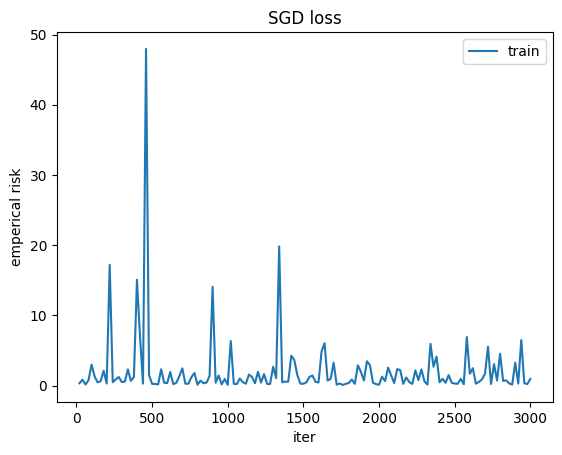

In [68]:
model = GradientClassifier(empirical_risk='exponential', lr=0.05, max_iter=3000)
model.fit_with_known_bwst(X_train_sgd, y_train_sgd, 0.0, 1.0)
y_pr = model.predict(X_test_sgd)
print("model accuracy")
print(model.score(y_test_sgd, y_pr))

x_ticks = []
for i in range(len(model.history_accuracy)):
    x_ticks.append(i*20 + 20)
plt.plot(x_ticks, model.history_emp, label='train')
plt.legend()
plt.title("SGD loss")
plt.xlabel('iter')
plt.ylabel('emperical risk')
plt.show()

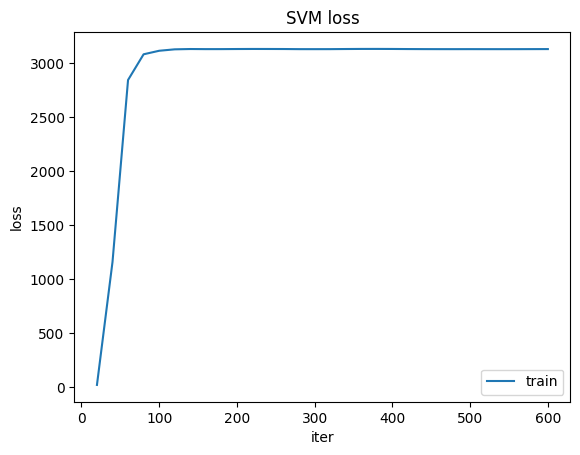

In [69]:
model = SVMClassifier(kernel="linear", polynom_degree=1, lr=0.05, C=10, max_iter=3000)
model.fit(X_train_svm, y_train_svm)
y_pred = model.predict(X_test_svm)
accuracy_score(y_test_svm, y_pred)

x_ticks = []
for i in range(len(model.history_accuracy)):
    x_ticks.append(i*20 + 20)

plt.plot(x_ticks, model.history_loss, label='train')
plt.legend()
plt.title("SVM loss")
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

## accuracy curve

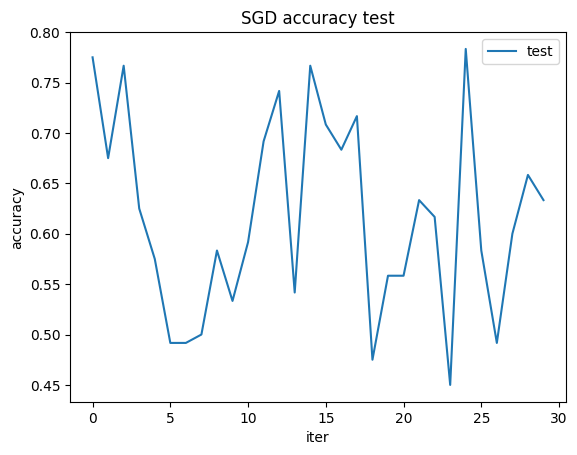

In [73]:
model = GradientClassifierForTest(empirical_risk='exponential', lr=0.05, max_iter=3000)
model.fit_with_known_bwst(X_train_sgd, y_train_sgd, X_test_sgd, y_test_sgd, 0.0, 1.0)

plt.plot(range(len(model.history_accuracy)), model.history_accuracy, label='test')
plt.legend()
plt.title("SGD accuracy test")
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.show()

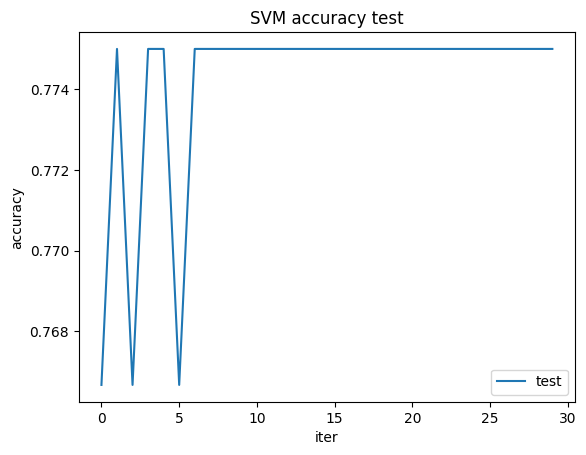

In [74]:
model = SVMClassifierForTest(kernel="linear", polynom_degree=1, lr=0.05, C=10, max_iter=3000)
model.fit(X_train_svm, y_train_svm, X_test_svm, y_test_svm)

plt.plot(range(len(model.history_accuracy)), model.history_accuracy, label='test')
plt.legend()
plt.title("SVM accuracy test")
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.show()

## different splits

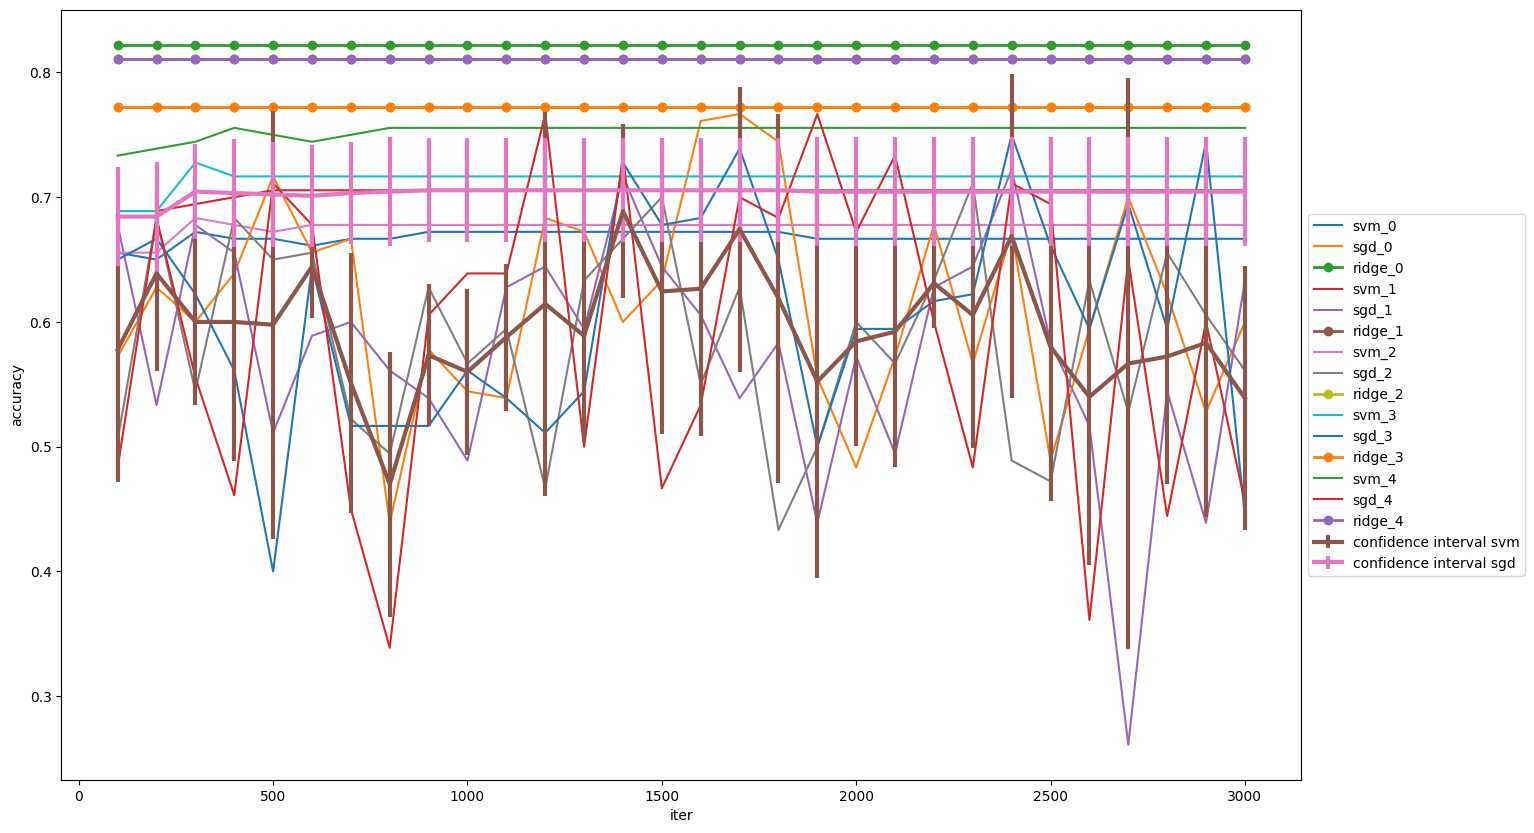

In [77]:
x_ticks = []
for i in range(30):
    x_ticks.append(i*100 + 100)

plt.figure(figsize=(16,10))
svm_all_accur= []
sgd_accur_all= []
for irs in range(5):

    X_train, X_test, y_train, y_test = train_test_split(X_reduced_svm, df_y_low, test_size=0.3, random_state=irs)
    model = SVMClassifierForTest(kernel="linear", polynom_degree=1, lr=0.05, C=10, max_iter=3000)
    model.fit(X_train, y_train, X_test, y_test)
    svm_all_accur.append(model.history_accuracy)
    plt.plot(x_ticks, model.history_accuracy, label=f"svm_{irs}")

    X_train, X_test, y_train, y_test = train_test_split(X_reduced_sgd, df_y_low, test_size=0.3, random_state=irs)
    model = GradientClassifierForTest(empirical_risk='exponential', lr=0.05, max_iter=3000)
    model.fit_with_known_bwst(X_train, y_train, X_test, y_test, 0.5, 1.75)
    sgd_accur_all.append(model.history_accuracy)
    plt.plot(x_ticks, model.history_accuracy, label=f"sgd_{irs}")

    model = RidgeClassifier(max_tau=1)
    model.fit(X_train, y_train)
    y_pr = model.predict(X_test)
    err_ridge = model.score(y_test, y_pr)
    plt.plot(x_ticks, np.repeat(err_ridge, 30), label=f"ridge_{irs}", linewidth=2, marker="o")


sgd_accur_all_arr = np.array(sgd_accur_all)
yy_sgd = [confidence_interval(sgd_accur_all_arr[:, t])[0] for t in range(len(x_ticks))]
xx_sgd = [confidence_interval(sgd_accur_all_arr[:, t])[1] for t in range(len(x_ticks))]
plt.errorbar(x_ticks, yy_sgd, xx_sgd, label="confidence interval svm", linewidth=3)
svm_all_accur_arr = np.array(svm_all_accur)
yy_svm = [confidence_interval(svm_all_accur_arr[:, t])[0] for t in range(len(x_ticks))]
xx_svm = [confidence_interval(svm_all_accur_arr[:, t])[1] for t in range(len(x_ticks))]
plt.errorbar(x_ticks, yy_svm, xx_svm, label="confidence interval sgd", linewidth=3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.show()